In [41]:
import timm
deit = timm.create_model('deit_tiny_patch16_224', pretrained=False)

In [46]:
import torch
def grayscale_weighted_3ch(x):
    weights = torch.tensor([0.2989, 0.5870, 0.1140], device=x.device).view(1, 3, 1, 1)
    gray = (x * weights).sum(dim=1, keepdim=True)  # (B, 1, H, W)
    return gray.repeat(1, 3, 1, 1)

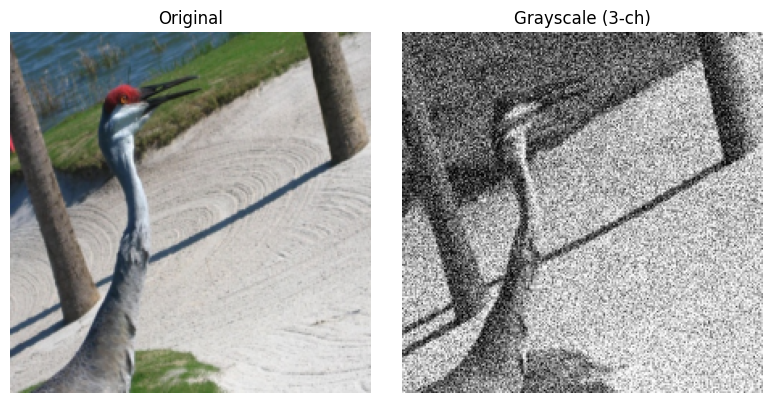

In [50]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# Define your grayscale conversion function
def grayscale_weighted_3ch(x):
    weights = torch.tensor([0.2989, 0.5870, 0.1140], device=x.device).view(1, 3, 1, 1)
    gray = (x * weights).sum(dim=1, keepdim=True)  # (1, 1, H, W)
    return gray.repeat(1, 3, 1, 1)  # (1, 3, H, W)

def add_gaussian_noise(x, mean=0.0, std=0.1):
    noise = torch.randn_like(x) * std + mean
    return torch.clamp(x + noise, 0.0, 1.0)

# Load an image and convert it to a tensor
img_path = "data/images/2007_000068.jpg"  # Replace with your image path
image = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),  # Converts to [0,1] float tensor, shape (3, H, W)
])

img_tensor = transform(image).unsqueeze(0)  # Add batch dim: (1, 3, H, W)

# Apply grayscale conversion
gray_tensor = add_gaussian_noise(img_tensor, std=0.25)
gray_tensor = grayscale_weighted_3ch(gray_tensor)

# Convert tensors to numpy for visualization
original_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
gray_np = gray_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grayscale (3-ch)")
plt.imshow(gray_np)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import torch
import torch.nn as nn
from functools import partial

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_


def grayscale_weighted_3ch(x):
    weights = torch.tensor([0.2989, 0.5870, 0.1140], device=x.device).view(1, 3, 1, 1)
    gray = (x * weights).sum(dim=1, keepdim=True)  # (1, 1, H, W)
    return gray.repeat(1, 3, 1, 1)  # (1, 3, H, W)

def add_gaussian_noise(x, mean=0.0, std=0.1):
    noise = torch.randn_like(x) * std + mean
    return torch.clamp(x + noise, 0.0, 1.0)

class ViTColorizationDecoder(nn.Module):
    def __init__(self, embed_dim=384):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 256, kernel_size=4, stride=2, padding=1),  # 14 → 28
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),        # 28 → 56
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),         # 56 → 112
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),          # 112 → 224
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=1)                                           # 224x224x3 output
        )

    def forward(self, x):
        B, N, C = x.shape
        H = W = int(N ** 0.5)
        x = x.permute(0, 2, 1).reshape(B, C, H, W)
        return self.decoder(x)

class JigsawVisionTransformer(VisionTransformer):
    def __init__(self, do_jigsaw, do_coloring, do_classification, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_patches = self.patch_embed.num_patches
        self.do_jigsaw = do_jigsaw
        self.do_coloring = do_coloring
        self.do_classification = do_classification

        if self.do_jigsaw:
            self.jigsaw = torch.nn.Sequential(*[torch.nn.Linear(self.embed_dim, self.embed_dim),
                                              torch.nn.ReLU(),
                                              torch.nn.Linear(self.embed_dim, self.embed_dim),
                                              torch.nn.ReLU(),
                                              torch.nn.Linear(self.embed_dim, self.num_patches)])
        
        self.coloring_decoder = ViTColorizationDecoder(embed_dim=self.embed_dim)

    def forward_jigsaw(self, x):

        x = add_gaussian_noise(x)
        x = grayscale_weighted_3ch(x)
        x = self.patch_embed(x)

        # append cls token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        cls_pos_embed = self.pos_embed[:, :1, :]
        cls_tokens = cls_tokens + cls_pos_embed
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        x = self.blocks(x)
        x = self.norm(x)
        x = self.jigsaw(x[:, 1:])       # TO BE DEFINED
        return x

    def forward_cls(self, x): 
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x[:, 0])
        return x
    
    def forward_denoising_coloring(self, x): 
        x = add_gaussian_noise(x)
        x = grayscale_weighted_3ch(x)
        x = self.patch_embed(x)
    
        x = x + self.pos_embed[:, 1:, :]

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = self.blocks(x)
        x = self.norm(x)
        x = x[:, 1:]  # remove cls token
        x = self.coloring_decoder(x)
        return x

    def forward(self, x):
        x = self.patch_embed(x)
        pred_cls = self.forward_cls(x)
        if self.do_jigsaw:
            pred_jigsaw = self.forward_jigsaw(x)
            outs.pred_jigsaw = pred_jigsaw
            outs.gt_jigsaw = targets_jigsaw
        return outs


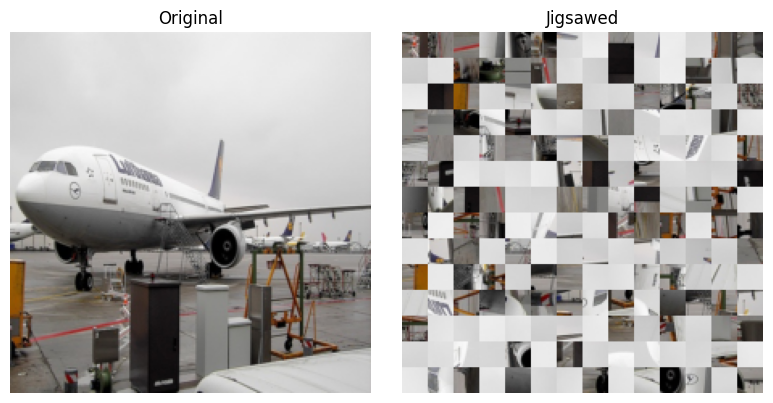

In [3]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Your jigsaw function for a single image tensor
def jigsaw_image_tensor(image: torch.Tensor, n_patches: int = 14):
    """
    image: torch tensor (C, H, W)
    Returns:
        transformed_image: torch.Tensor (C, H, W)
        pos_vector: torch.Tensor (N,)
        rot_vector: torch.Tensor (N,)
    """
    C, H, W = image.shape
    patch_h = H // n_patches
    patch_w = W // n_patches
    patches = []

    for i in range(n_patches):
        for j in range(n_patches):
            patch = image[:, i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
            patches.append(patch)

    N = n_patches ** 2
    permuted_indices = torch.randperm(N)
    pos_vector = permuted_indices.clone()
    rot_vector = torch.randint(0, 4, (N,))

    shuffled_patches = []
    for i, idx in enumerate(permuted_indices):
        patch = patches[idx]
        rotated_patch = torch.rot90(patch, k=rot_vector[i].item(), dims=[1, 2])
        shuffled_patches.append(rotated_patch)

    # Reconstruct image
    transformed_image = torch.zeros_like(image)
    for idx, patch in enumerate(shuffled_patches):
        i, j = divmod(idx, n_patches)
        transformed_image[:, i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w] = patch

    return transformed_image, pos_vector, rot_vector

# --- Step 1: Load image with PIL ---
image_path = "data/images/2007_000033.jpg"  # Change this to your actual image path
img_pil = Image.open(image_path).convert("RGB")

# --- Step 2: Transform to tensor ---
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),  # Converts to (C, H, W) and scales to [0, 1]
])
img_tensor = transform(img_pil)

# --- Step 3: Apply jigsaw ---
jigsaw_img, pos_vec, rot_vec = jigsaw_image_tensor(img_tensor.clone(), n_patches=14)

# --- Step 4: Visualize ---
def show_tensor_img(img_tensor, title=""):
    img_np = img_tensor.permute(1, 2, 0).numpy()  # (H, W, C)
    plt.imshow(img_np)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
show_tensor_img(img_tensor, title="Original")

plt.subplot(1, 2, 2)
show_tensor_img(jigsaw_img, title="Jigsawed")

plt.tight_layout()
plt.show()

In [9]:
from models.full_model import MultiTaskDeiT

# Initialize the model  

model = MultiTaskDeiT(
    img_size=224,
    patch_size=16,
    in_chans=3,
    embed_dim=192,
    depth=12,
    num_heads=3,
    mlp_ratio=4.,
    qkv_bias=True,
    do_jigsaw=True,
    do_coloring=True,
    do_classification=True,
)

In [10]:
print(model)

MultiTaskDeiT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 7,342,323
